Task 1: Audio Data Collection and Quality Assessment

In [2]:
# --- TASK 1: Selection + Quality Assessment (UrbanSound8K) ---

from pathlib import Path
import shutil, random, os
import numpy as np
import pandas as pd
import librosa
import warnings
warnings.filterwarnings('ignore')

# 1) SET THIS: points to the folder that contains fold1 ... fold10
AUDIO_ROOT = Path(r"D:\DU-SEM2\Period 1\Data Collection\Lab 3 Audio Folder\archive\audio files").parent  # <-- adjust if needed

# UrbanSound8K: classID -> class name
CLASS_MAP = {
    0: "air_conditioner",
    1: "car_horn",
    2: "children_playing",
    3: "dog_bark",
    4: "drilling",
    5: "engine_idling",
    6: "gun_shot",
    7: "jackhammer",
    8: "siren",
    9: "street_music",
}

# Choose your 4 classes (edit this list)
TARGET_CLASSES = ["dog_bark", "drilling", "siren", "street_music"]  # <-- change if you want different four

# Reproducible selection
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

# Output dirs
OUT_ROOT = AUDIO_ROOT / "selected_4x20"
OUT_ROOT.mkdir(exist_ok=True)

print("AUDIO_ROOT ->", AUDIO_ROOT)
print("Exists:", AUDIO_ROOT.exists())
print("Will save selected files to ->", OUT_ROOT)


AUDIO_ROOT -> D:\DU-SEM2\Period 1\Data Collection\Lab 3 Audio Folder\archive
Exists: True
Will save selected files to -> D:\DU-SEM2\Period 1\Data Collection\Lab 3 Audio Folder\archive\selected_4x20


In [4]:
def class_from_filename(fn: str) -> str:
    # UrbanSound8K: <sliceID>-<classID>-<takeID>-<index>.wav
    stem = Path(fn).stem
    parts = stem.split("-")
    try:
        if len(parts) >= 2:
            cid = int(parts[1])
            return CLASS_MAP.get(cid, "unknown")
    except:
        pass
    return "unknown"

# Gather all wavs from fold1..fold10 (recursive)
all_wavs = sorted(AUDIO_ROOT.rglob("*.wav"))

rows = []
for p in all_wavs:
    lbl = class_from_filename(p.name)
    # Try to infer fold from parent folder name if available (fold1..fold10)
    fold = None
    for parent in p.parents:
        if parent.name.lower().startswith("fold"):
            fold = parent.name
            break
    rows.append({"path": p.as_posix(), "filename": p.name, "label": lbl, "fold": fold})

all_df = pd.DataFrame(rows)
print("Total wavs found:", len(all_df))
print("Label counts:\n", all_df["label"].value_counts(dropna=False))
all_df.head(5)


Total wavs found: 8812
Label counts:
 label
dog_bark            1020
street_music        1020
drilling            1020
jackhammer          1000
engine_idling       1000
children_playing    1000
air_conditioner     1000
siren                949
car_horn             429
gun_shot             374
Name: count, dtype: int64


,path,filename,label,fold
0,D:/DU-SEM2/Period 1/Data Collection/Lab 3 Audi...,101415-3-0-2.wav,dog_bark,fold1
1,D:/DU-SEM2/Period 1/Data Collection/Lab 3 Audi...,101415-3-0-3.wav,dog_bark,fold1
2,D:/DU-SEM2/Period 1/Data Collection/Lab 3 Audi...,101415-3-0-8.wav,dog_bark,fold1
3,D:/DU-SEM2/Period 1/Data Collection/Lab 3 Audi...,102106-3-0-0.wav,dog_bark,fold1
4,D:/DU-SEM2/Period 1/Data Collection/Lab 3 Audi...,102305-6-0-0.wav,gun_shot,fold1


In [6]:
# Check that requested classes exist and have >=20 files each
problems = []
for cls in TARGET_CLASSES:
    n = (all_df["label"] == cls).sum()
    if n < 20:
        problems.append(f"{cls}: only {n} files found (<20)")
if problems:
    raise RuntimeError("Class availability issue:\n" + "\n".join(problems))

# Select 20 per class (stable random)
selected_rows = []
for cls in TARGET_CLASSES:
    pool = all_df[all_df["label"] == cls].sample(frac=1.0, random_state=RANDOM_SEED)  # shuffle
    take = pool.head(20).copy()
    selected_rows.append(take)

selected_df = pd.concat(selected_rows, ignore_index=True)
print("Selected per class:")
print(selected_df["label"].value_counts())
assert len(selected_df) == 80, f"Expected 80 files total, got {len(selected_df)}"
selected_df.head(80)


Selected per class:
label
dog_bark        20
drilling        20
siren           20
street_music    20
Name: count, dtype: int64


,path,filename,label,fold
0,D:/DU-SEM2/Period 1/Data Collection/Lab 3 Audi...,173993-3-0-39.wav,dog_bark,fold5
1,D:/DU-SEM2/Period 1/Data Collection/Lab 3 Audi...,101281-3-0-5.wav,dog_bark,fold6
2,D:/DU-SEM2/Period 1/Data Collection/Lab 3 Audi...,178497-3-0-1.wav,dog_bark,fold5
3,D:/DU-SEM2/Period 1/Data Collection/Lab 3 Audi...,164312-3-3-0.wav,dog_bark,fold1
4,D:/DU-SEM2/Period 1/Data Collection/Lab 3 Audi...,125574-3-0-0.wav,dog_bark,fold6
...,...,...,...,...
75,D:/DU-SEM2/Period 1/Data Collection/Lab 3 Audi...,149255-9-0-7.wav,street_music,fold9
76,D:/DU-SEM2/Period 1/Data Collection/Lab 3 Audi...,132162-9-1-73.wav,street_music,fold6
77,D:/DU-SEM2/Period 1/Data Collection/Lab 3 Audi...,98202-9-1-5.wav,street_music,fold2
78,D:/DU-SEM2/Period 1/Data Collection/Lab 3 Audi...,149255-9-0-5.wav,street_music,fold9


In [8]:
# Copy into selected_4x20/<class>/
for cls in TARGET_CLASSES:
    (OUT_ROOT / cls).mkdir(parents=True, exist_ok=True)

copied = []
for _, r in selected_df.iterrows():
    src = Path(r["path"])
    dst = OUT_ROOT / r["label"] / src.name
    if not dst.exists():
        shutil.copy2(src, dst)
    copied.append(dst.as_posix())

selected_df = selected_df.assign(copied_to=copied)
selected_manifest = OUT_ROOT / "selected_manifest.csv"
selected_df.to_csv(selected_manifest, index=False)
print("Copied 80 files into:", OUT_ROOT)
print("Manifest ->", selected_manifest)


Copied 80 files into: D:\DU-SEM2\Period 1\Data Collection\Lab 3 Audio Folder\archive\selected_4x20
Manifest -> D:\DU-SEM2\Period 1\Data Collection\Lab 3 Audio Folder\archive\selected_4x20\selected_manifest.csv


In [10]:
# Uniform load settings (preferred)
TARGET_SR = 44100   # sampling rate
MONO = True         # single channel

def clip_percent(y, thr=0.999):
    return float(np.mean(np.abs(y) >= thr) * 100.0)

def dc_offset_abs(y):
    return float(abs(np.mean(y))) if y.size else 0.0

def rms_mean(y):
    # librosa.feature.rms returns framewise; here a simple waveform RMS:
    return float(np.sqrt(np.mean(y**2))) if y.size else 0.0

quality_rows = []
for _, r in selected_df.iterrows():
    p = r["copied_to"]
    try:
        y, sr = librosa.load(p, sr=TARGET_SR, mono=MONO)
        dur = librosa.get_duration(y=y, sr=sr)
        row = {
            "path": p,
            "filename": Path(p).name,
            "label": r["label"],
            "sample_rate": sr,
            "duration_sec": dur,
            "rms_mean": rms_mean(y),
            "clip_percent": clip_percent(y),
            "dc_offset": dc_offset_abs(y),
        }
    except Exception as e:
        row = {
            "path": p,
            "filename": Path(p).name,
            "label": r["label"],
            "error": str(e),
        }
    quality_rows.append(row)

quality_df = pd.DataFrame(quality_rows)
quality_csv = OUT_ROOT / "quality_overview.csv"
quality_df.to_csv(quality_csv, index=False)
print("Saved quality overview ->", quality_csv)
quality_df.head(10)


Saved quality overview -> D:\DU-SEM2\Period 1\Data Collection\Lab 3 Audio Folder\archive\selected_4x20\quality_overview.csv


,path,filename,label,sample_rate,duration_sec,rms_mean,clip_percent,dc_offset
0,D:/DU-SEM2/Period 1/Data Collection/Lab 3 Audi...,173993-3-0-39.wav,dog_bark,44100,4.000000,0.018957,0.000000,0.000004
1,D:/DU-SEM2/Period 1/Data Collection/Lab 3 Audi...,101281-3-0-5.wav,dog_bark,44100,4.000000,0.059230,0.000000,0.000347
2,D:/DU-SEM2/Period 1/Data Collection/Lab 3 Audi...,178497-3-0-1.wav,dog_bark,44100,4.000000,0.009280,0.000000,0.000002
3,D:/DU-SEM2/Period 1/Data Collection/Lab 3 Audi...,164312-3-3-0.wav,dog_bark,44100,1.677392,0.020836,0.000000,0.000003
4,D:/DU-SEM2/Period 1/Data Collection/Lab 3 Audi...,125574-3-0-0.wav,dog_bark,44100,1.450000,0.216452,0.675581,0.006630
5,D:/DU-SEM2/Period 1/Data Collection/Lab 3 Audi...,66587-3-2-0.wav,dog_bark,44100,0.516463,0.129515,0.000000,0.000042
6,D:/DU-SEM2/Period 1/Data Collection/Lab 3 Audi...,344-3-0-0.wav,dog_bark,44100,0.647664,0.345993,0.000000,0.002299
7,D:/DU-SEM2/Period 1/Data Collection/Lab 3 Audi...,191687-3-0-11.wav,dog_bark,44100,4.000000,0.083744,0.000000,0.000253
8,D:/DU-SEM2/Period 1/Data Collection/Lab 3 Audi...,57553-3-0-0.wav,dog_bark,44100,1.715420,0.060478,0.000000,0.001077
9,D:/DU-SEM2/Period 1/Data Collection/Lab 3 Audi...,155320-3-0-0.wav,dog_bark,44100,1.139773,0.174878,0.005968,0.000017


In [12]:
# Heuristics — tweak thresholds if needed
MIN_DURATION = 0.25     # seconds; very short clips are suspicious
MAX_CLIP_PCT = 1.0      # >1% samples hitting ceiling suggests clipping
MIN_RMS = 0.005         # very low average level (approx heuristic)
MAX_DC = 0.01           # excessive DC offset

flags = []
for _, r in quality_df.iterrows():
    reasons = []
    if pd.notna(r.get("duration_sec", np.nan)) and r["duration_sec"] < MIN_DURATION:
        reasons.append(f"short<{MIN_DURATION}s")
    if pd.notna(r.get("clip_percent", np.nan)) and r["clip_percent"] > MAX_CLIP_PCT:
        reasons.append(f"clipping>{MAX_CLIP_PCT}%")
    if pd.notna(r.get("rms_mean", np.nan)) and r["rms_mean"] < MIN_RMS:
        reasons.append(f"low_rms<{MIN_RMS}")
    if pd.notna(r.get("dc_offset", np.nan)) and r["dc_offset"] > MAX_DC:
        reasons.append(f"dc_offset>{MAX_DC}")
    flags.append(", ".join(reasons))

quality_df["flags"] = flags
problems_df = quality_df[quality_df["flags"].astype(str).str.len() > 0]
print(f"Files with potential issues: {len(problems_df)}")
problems_df.head(10)


Files with potential issues: 4


,path,filename,label,sample_rate,duration_sec,rms_mean,clip_percent,dc_offset,flags
41,D:/DU-SEM2/Period 1/Data Collection/Lab 3 Audi...,74726-8-0-1.wav,siren,44100,4.0,0.003887,0.0,1.170792e-05,low_rms<0.005
52,D:/DU-SEM2/Period 1/Data Collection/Lab 3 Audi...,159738-8-0-19.wav,siren,44100,4.0,0.000411,0.0,6.229867e-07,low_rms<0.005
55,D:/DU-SEM2/Period 1/Data Collection/Lab 3 Audi...,40722-8-0-0.wav,siren,44100,4.0,0.223066,0.0,7.933962e-02,dc_offset>0.01
65,D:/DU-SEM2/Period 1/Data Collection/Lab 3 Audi...,36263-9-0-2.wav,street_music,44100,4.0,0.216850,0.0,1.019879e-02,dc_offset>0.01


In [14]:
print("=== TASK 1 NOTES FOR REPORT ===\n")

print("1) Selection:")
print(f"- Chosen classes: {', '.join(TARGET_CLASSES)}")
print("- Exactly 20 files were selected per class (total 80) from fold1–fold10.")
print(f"- Files were copied to: {OUT_ROOT}")

print("\n2) Preferred uniform settings:")
print("- Sampling rate: 44,100 Hz")
print("- Channels: Mono")
print("- Format on disk: WAV (16-bit PCM recommended)")
print("- Processing: All files are resampled to 44.1 kHz and converted to mono on load.")

print("\n3) Potential audio quality issues (and our flags):")
print("- Very short duration clips (default threshold < 0.25 s)")
print("- Clipping/distortion (> 1.0% of samples at full-scale)")
print("- Low overall level (RMS mean < 0.005)")
print("- Excessive DC offset (|mean| > 0.01)")
print("See CSV:", OUT_ROOT / 'quality_overview.csv')

if 'problems_df' in globals() and len(problems_df):
    print(f"\nFlagged {len(problems_df)} file(s). Review and optionally replace them from the remaining pool.")
else:
    print("\nNo files were flagged by current thresholds.")


=== TASK 1 NOTES FOR REPORT ===

1) Selection:
- Chosen classes: dog_bark, drilling, siren, street_music
- Exactly 20 files were selected per class (total 80) from fold1–fold10.
- Files were copied to: D:\DU-SEM2\Period 1\Data Collection\Lab 3 Audio Folder\archive\selected_4x20

2) Preferred uniform settings:
- Sampling rate: 44,100 Hz
- Channels: Mono
- Format on disk: WAV (16-bit PCM recommended)
- Processing: All files are resampled to 44.1 kHz and converted to mono on load.

3) Potential audio quality issues (and our flags):
- Very short duration clips (default threshold < 0.25 s)
- Clipping/distortion (> 1.0% of samples at full-scale)
- Low overall level (RMS mean < 0.005)
- Excessive DC offset (|mean| > 0.01)
See CSV: D:\DU-SEM2\Period 1\Data Collection\Lab 3 Audio Folder\archive\selected_4x20\quality_overview.csv

Flagged 4 file(s). Review and optionally replace them from the remaining pool.


Task 2: Data Labelling and Frequency Plot Analysis

In [17]:
from pathlib import Path
import pandas as pd

# Point this to the same AUDIO_ROOT and OUT_ROOT you used in Task 1
AUDIO_ROOT = Path(r"D:\DU-SEM2\Period 1\Data Collection\Lab 3 Audio Folder\archive")
OUT_ROOT   = AUDIO_ROOT / "selected_4x20"

# Load Task-1 manifest
manifest_path = OUT_ROOT / "selected_manifest.csv"
selected_df = pd.read_csv(manifest_path)

# Derive label from folder name (robust) and cross-check with any existing label column
def label_from_parent(path_str: str) -> str:
    p = Path(path_str)
    return p.parent.name  # parent folder is the class name

selected_df["label_folder"] = selected_df["copied_to"].apply(label_from_parent)

# Keep a single 'label' column (prefer folder-derived, which is definitive)
selected_df["label"] = selected_df["label_folder"]
selected_df = selected_df.drop(columns=[c for c in ["label_folder"] if c in selected_df.columns])

# Save a labeled manifest for downstream steps
labeled_manifest = OUT_ROOT / "labeled_manifest.csv"
selected_df.to_csv(labeled_manifest, index=False)

print("Saved labeled manifest ->", labeled_manifest)
print("\nCounts (20 each expected):")
print(selected_df["label"].value_counts())
selected_df.head(5)


Saved labeled manifest -> D:\DU-SEM2\Period 1\Data Collection\Lab 3 Audio Folder\archive\selected_4x20\labeled_manifest.csv

Counts (20 each expected):
label
dog_bark        20
drilling        20
siren           20
street_music    20
Name: count, dtype: int64


,path,filename,label,fold,copied_to
0,D:/DU-SEM2/Period 1/Data Collection/Lab 3 Audi...,173993-3-0-39.wav,dog_bark,fold5,D:/DU-SEM2/Period 1/Data Collection/Lab 3 Audi...
1,D:/DU-SEM2/Period 1/Data Collection/Lab 3 Audi...,101281-3-0-5.wav,dog_bark,fold6,D:/DU-SEM2/Period 1/Data Collection/Lab 3 Audi...
2,D:/DU-SEM2/Period 1/Data Collection/Lab 3 Audi...,178497-3-0-1.wav,dog_bark,fold5,D:/DU-SEM2/Period 1/Data Collection/Lab 3 Audi...
3,D:/DU-SEM2/Period 1/Data Collection/Lab 3 Audi...,164312-3-3-0.wav,dog_bark,fold1,D:/DU-SEM2/Period 1/Data Collection/Lab 3 Audi...
4,D:/DU-SEM2/Period 1/Data Collection/Lab 3 Audi...,125574-3-0-0.wav,dog_bark,fold6,D:/DU-SEM2/Period 1/Data Collection/Lab 3 Audi...


Example file chosen per class:


,label,copied_to
0,dog_bark,D:/DU-SEM2/Period 1/Data Collection/Lab 3 Audi...
1,drilling,D:/DU-SEM2/Period 1/Data Collection/Lab 3 Audi...
2,siren,D:/DU-SEM2/Period 1/Data Collection/Lab 3 Audi...
3,street_music,D:/DU-SEM2/Period 1/Data Collection/Lab 3 Audi...


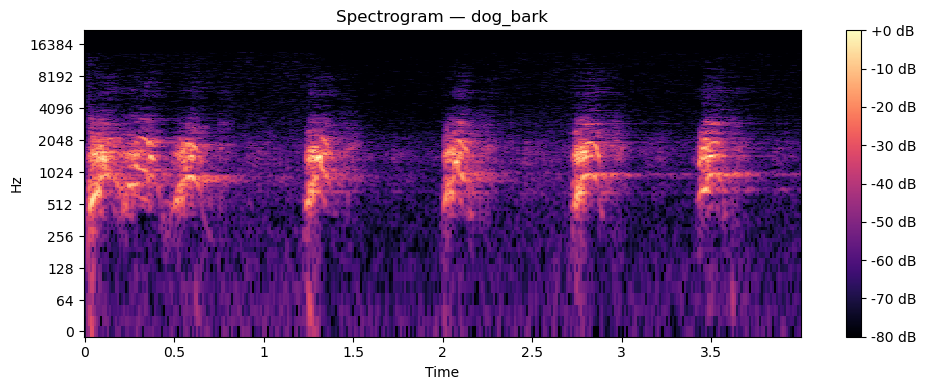

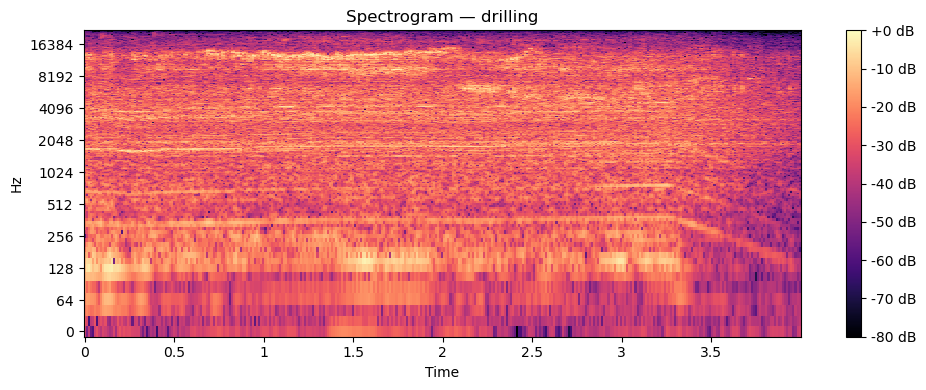

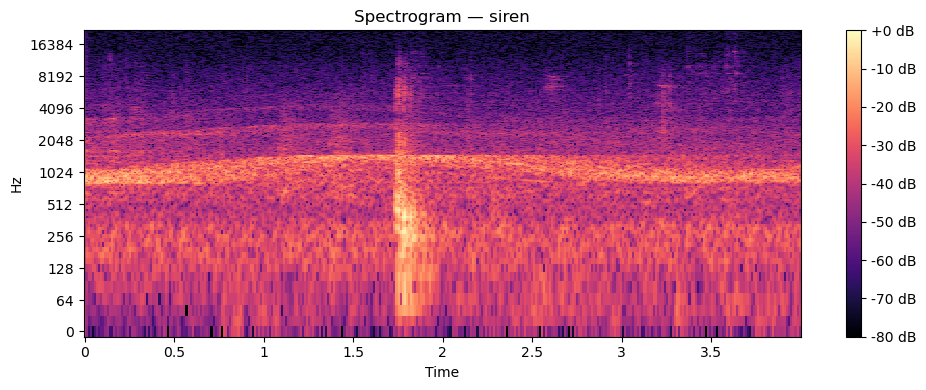

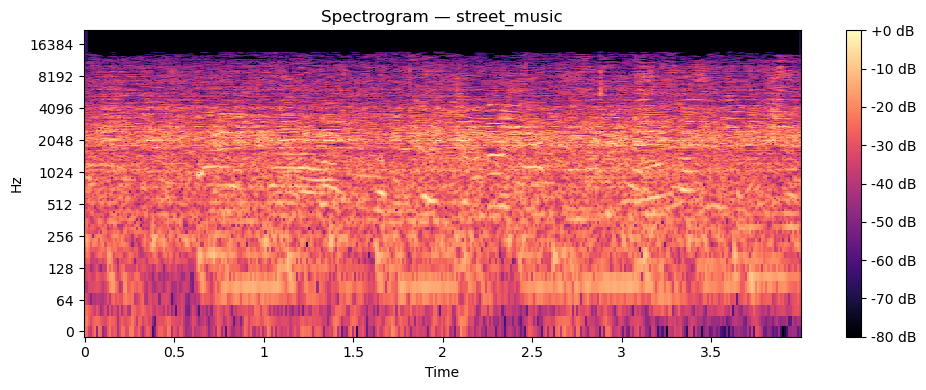


 Spectrograms generated and displayed successfully!
Saved images in: D:\DU-SEM2\Period 1\Data Collection\Lab 3 Audio Folder\archive\selected_4x20\Spectrograms_Task2


In [19]:
import numpy as np
import librosa, librosa.display
import matplotlib.pyplot as plt
from pathlib import Path

# Ensure output folder exists
SPEC_DIR = OUT_ROOT / "Spectrograms_Task2"
SPEC_DIR.mkdir(exist_ok=True)

# Pick one example file per class (alphabetically)
examples = (
    selected_df.sort_values("copied_to")
               .groupby("label", as_index=False)
               .first()[["label", "copied_to"]]
)

print("Example file chosen per class:")
display(examples)

# Code snippet template for report
CODE_SNIPPET = r"""
import numpy as np
import librosa, librosa.display
import matplotlib.pyplot as plt

y, sr = librosa.load("PATH_TO_FILE.wav", sr=44100, mono=True)
S = np.abs(librosa.stft(y, n_fft=2048, hop_length=512))
D = librosa.amplitude_to_db(S, ref=np.max)
plt.figure(figsize=(10, 4))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log', hop_length=512)
plt.title('Spectrogram — LABEL')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()
""".strip()

def plot_and_save_spectrogram(wav_path: str, label: str, out_png: Path, show_plot: bool = True):
    """Generate spectrogram, save to file, and optionally display it."""
    y, sr = librosa.load(wav_path, sr=44100, mono=True)
    S = np.abs(librosa.stft(y, n_fft=2048, hop_length=512))
    D = librosa.amplitude_to_db(S, ref=np.max)

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log', hop_length=512)
    plt.title(f"Spectrogram — {label}")
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.savefig(out_png, dpi=160)
    
    if show_plot:
        plt.show()  # <-- Displays in notebook
    
    plt.close()

# Generate and display all four spectrograms
txt_files = []
for _, row in examples.iterrows():
    label = row["label"]
    p = Path(row["copied_to"])
    png_path = SPEC_DIR / f"{p.stem}__{label}.png"

    # Save + show plot
    plot_and_save_spectrogram(p.as_posix(), label, png_path, show_plot=True)

    # Save code snippet for report
    code_txt = CODE_SNIPPET.replace("PATH_TO_FILE.wav", p.as_posix()).replace("LABEL", label)
    txt_path = SPEC_DIR / f"{p.stem}__{label}_code.txt"
    with open(txt_path, "w", encoding="utf-8") as f:
        f.write(code_txt)
    txt_files.append(txt_path.as_posix())

print("\n Spectrograms generated and displayed successfully!")
print("Saved images in:", SPEC_DIR)


In [20]:
print("=== TASK 2 NOTES FOR REPORT ===\n")

print("1) Labelling:")
print("- Labels assigned from the parent folder name in 'selected_4x20/<class>/*.wav'.")
print("- Verified 20 files per class in labeled_manifest.csv.")

print("\n2) Frequency Plot Analysis (Spectrograms):")
print("- One representative file selected per class (alphabetical order for reproducibility).")
print("- STFT parameters: n_fft=2048, hop_length=512; amplitude shown in dB; log frequency axis.")
print("- Spectrogram PNGs saved in:", (OUT_ROOT / 'Spectrograms_Task2').as_posix())
print("- For each PNG, a matching *_code.txt file contains the exact code used to generate the plot (as required).")


=== TASK 2 NOTES FOR REPORT ===

1) Labelling:
- Labels assigned from the parent folder name in 'selected_4x20/<class>/*.wav'.
- Verified 20 files per class in labeled_manifest.csv.

2) Frequency Plot Analysis (Spectrograms):
- One representative file selected per class (alphabetical order for reproducibility).
- STFT parameters: n_fft=2048, hop_length=512; amplitude shown in dB; log frequency axis.
- Spectrogram PNGs saved in: D:/DU-SEM2/Period 1/Data Collection/Lab 3 Audio Folder/archive/selected_4x20/Spectrograms_Task2
- For each PNG, a matching *_code.txt file contains the exact code used to generate the plot (as required).


Task 3: Feature Extraction and Data Cleaning

In [24]:
from pathlib import Path
import pandas as pd

# Point to your Task-1/2 output
AUDIO_ROOT = Path(r"D:\DU-SEM2\Period 1\Data Collection\Lab 3 Audio Folder\archive")
OUT_ROOT   = AUDIO_ROOT / "selected_4x20"

manifest_path = OUT_ROOT / "labeled_manifest.csv"
selected_df = pd.read_csv(manifest_path)

print("Rows in manifest (expected 80):", len(selected_df))
print(selected_df["label"].value_counts())
selected_df.head(3)


Rows in manifest (expected 80): 80
label
dog_bark        20
drilling        20
siren           20
street_music    20
Name: count, dtype: int64


,path,filename,label,fold,copied_to
0,D:/DU-SEM2/Period 1/Data Collection/Lab 3 Audi...,173993-3-0-39.wav,dog_bark,fold5,D:/DU-SEM2/Period 1/Data Collection/Lab 3 Audi...
1,D:/DU-SEM2/Period 1/Data Collection/Lab 3 Audi...,101281-3-0-5.wav,dog_bark,fold6,D:/DU-SEM2/Period 1/Data Collection/Lab 3 Audi...
2,D:/DU-SEM2/Period 1/Data Collection/Lab 3 Audi...,178497-3-0-1.wav,dog_bark,fold5,D:/DU-SEM2/Period 1/Data Collection/Lab 3 Audi...


In [26]:
import numpy as np
import librosa

def extract_features_for_file(path: str, sr_target: int = 44100) -> dict:
    """
    Returns a flat dict of temporal and frequency-domain features for one audio file.
    All signals are loaded mono at sr_target for consistency.
    """
    y, sr = librosa.load(path, sr=sr_target, mono=True)

    # ---- Temporal features
    zcr = librosa.feature.zero_crossing_rate(y)                     # framewise
    rms = librosa.feature.rms(y=y)                                  # framewise

    feats = {
        "zcr_mean": float(np.mean(zcr)),
        "zcr_std":  float(np.std(zcr)),
        "rms_mean": float(np.mean(rms)),
        "rms_std":  float(np.std(rms)),
    }

    # ---- Frequency-domain features
    centroid   = librosa.feature.spectral_centroid(y=y, sr=sr)      # proxy for "mean frequency"
    bandwidth  = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    rolloff85  = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.85)
    rolloff95  = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.95)

    feats.update({
        "spec_centroid_mean":  float(np.mean(centroid)),
        "spec_centroid_std":   float(np.std(centroid)),
        "spec_bandwidth_mean": float(np.mean(bandwidth)),
        "spec_bandwidth_std":  float(np.std(bandwidth)),
        "spec_rolloff85_mean": float(np.mean(rolloff85)),
        "spec_rolloff95_mean": float(np.mean(rolloff95)),
    })

    # ---- Cepstral features (MFCC 1–13) — means & stds
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    for i in range(mfcc.shape[0]):
        feats[f"mfcc{i+1}_mean"] = float(np.mean(mfcc[i]))
        feats[f"mfcc{i+1}_std"]  = float(np.std(mfcc[i]))

    # Metadata
    feats["sample_rate"] = int(sr)
    feats["duration_sec"] = float(librosa.get_duration(y=y, sr=sr))
    return feats

# Run extraction for the 80 selected files
feature_rows = []
for _, r in selected_df.iterrows():
    p = r["copied_to"] if "copied_to" in r else r["path"]
    feats = extract_features_for_file(p)
    feats["path"] = p
    feats["filename"] = Path(p).name
    feats["label"] = r["label"]  # <-- class name column required
    feature_rows.append(feats)

features_df = pd.DataFrame(feature_rows)

# Save raw features
raw_csv = OUT_ROOT / "audio_features_raw.csv"
features_df.to_csv(raw_csv, index=False)
print("Saved raw features ->", raw_csv)
print("Rows:", len(features_df), "| Cols:", len(features_df.columns))
features_df.head(5)


Saved raw features -> D:\DU-SEM2\Period 1\Data Collection\Lab 3 Audio Folder\archive\selected_4x20\audio_features_raw.csv
Rows: 80 | Cols: 41


,zcr_mean,zcr_std,rms_mean,rms_std,spec_centroid_mean,spec_centroid_std,spec_bandwidth_mean,spec_bandwidth_std,spec_rolloff85_mean,spec_rolloff95_mean,...,mfcc11_std,mfcc12_mean,mfcc12_std,mfcc13_mean,mfcc13_std,sample_rate,duration_sec,path,filename,label
0,0.066872,0.029714,0.011018,0.015339,2508.185227,803.936672,2999.589123,792.462051,4089.061651,8745.101902,...,9.907068,8.712861,10.140412,7.217527,10.387053,44100,4.000000,D:/DU-SEM2/Period 1/Data Collection/Lab 3 Audi...,173993-3-0-39.wav,dog_bark
1,0.122239,0.031352,0.049719,0.031859,3497.259100,546.013145,2792.653399,278.763610,6387.184952,9682.264351,...,6.917099,-11.681520,5.730679,13.788867,5.739021,44100,4.000000,D:/DU-SEM2/Period 1/Data Collection/Lab 3 Audi...,101281-3-0-5.wav,dog_bark
2,0.051677,0.016107,0.003869,0.008428,2436.362032,919.868755,3368.771718,1372.042070,4632.509766,10013.938094,...,7.480713,-1.674402,8.598072,-1.148615,8.565052,44100,4.000000,D:/DU-SEM2/Period 1/Data Collection/Lab 3 Audi...,178497-3-0-1.wav,dog_bark
3,0.037948,0.013057,0.009332,0.018587,2271.862895,1050.692363,3289.175086,1433.071885,4722.157193,9194.083715,...,9.138638,-1.232464,7.944569,1.296386,5.611195,44100,1.677392,D:/DU-SEM2/Period 1/Data Collection/Lab 3 Audi...,164312-3-3-0.wav,dog_bark
4,0.020613,0.011791,0.089269,0.197084,2146.839112,852.602240,3717.176369,1054.213292,4530.413672,10369.012500,...,5.414447,0.763582,10.874232,4.854221,8.447422,44100,1.450000,D:/DU-SEM2/Period 1/Data Collection/Lab 3 Audi...,125574-3-0-0.wav,dog_bark


In [28]:
# 1) Drop all-NaN columns (empty)
clean_df = features_df.dropna(axis=1, how="all")

# 2) Drop constant columns (no variance -> irrelevant for modeling)
constant_cols = [c for c in clean_df.columns if clean_df[c].nunique(dropna=False) <= 1]
if constant_cols:
    clean_df = clean_df.drop(columns=constant_cols)

# 3) Drop duplicate columns (rare, but safe)
clean_df = clean_df.loc[:, ~clean_df.T.duplicated()]

# 4) Sanity checks for the assignment
assert len(clean_df) == 80, f"Expected 80 rows (4 classes x 20 files), got {len(clean_df)}"
assert "label" in clean_df.columns, "Class name column 'label' is missing!"
print("Class counts:\n", clean_df["label"].value_counts())

# Save final
final_csv = OUT_ROOT / "audio_features_cleaned.csv"
clean_df.to_csv(final_csv, index=False)

print("\n Final cleaned features ->", final_csv)
print("Rows:", len(clean_df), "| Cols:", len(clean_df.columns))
clean_df.head(5)


Class counts:
 label
dog_bark        20
drilling        20
siren           20
street_music    20
Name: count, dtype: int64

 Final cleaned features -> D:\DU-SEM2\Period 1\Data Collection\Lab 3 Audio Folder\archive\selected_4x20\audio_features_cleaned.csv
Rows: 80 | Cols: 40


,zcr_mean,zcr_std,rms_mean,rms_std,spec_centroid_mean,spec_centroid_std,spec_bandwidth_mean,spec_bandwidth_std,spec_rolloff85_mean,spec_rolloff95_mean,...,mfcc11_mean,mfcc11_std,mfcc12_mean,mfcc12_std,mfcc13_mean,mfcc13_std,duration_sec,path,filename,label
0,0.066872,0.029714,0.011018,0.015339,2508.185227,803.936672,2999.589123,792.462051,4089.061651,8745.101902,...,5.660527,9.907068,8.712861,10.140412,7.217527,10.387053,4.000000,D:/DU-SEM2/Period 1/Data Collection/Lab 3 Audi...,173993-3-0-39.wav,dog_bark
1,0.122239,0.031352,0.049719,0.031859,3497.259100,546.013145,2792.653399,278.763610,6387.184952,9682.264351,...,6.908829,6.917099,-11.681520,5.730679,13.788867,5.739021,4.000000,D:/DU-SEM2/Period 1/Data Collection/Lab 3 Audi...,101281-3-0-5.wav,dog_bark
2,0.051677,0.016107,0.003869,0.008428,2436.362032,919.868755,3368.771718,1372.042070,4632.509766,10013.938094,...,-6.943400,7.480713,-1.674402,8.598072,-1.148615,8.565052,4.000000,D:/DU-SEM2/Period 1/Data Collection/Lab 3 Audi...,178497-3-0-1.wav,dog_bark
3,0.037948,0.013057,0.009332,0.018587,2271.862895,1050.692363,3289.175086,1433.071885,4722.157193,9194.083715,...,-1.537593,9.138638,-1.232464,7.944569,1.296386,5.611195,1.677392,D:/DU-SEM2/Period 1/Data Collection/Lab 3 Audi...,164312-3-3-0.wav,dog_bark
4,0.020613,0.011791,0.089269,0.197084,2146.839112,852.602240,3717.176369,1054.213292,4530.413672,10369.012500,...,5.347489,5.414447,0.763582,10.874232,4.854221,8.447422,1.450000,D:/DU-SEM2/Period 1/Data Collection/Lab 3 Audi...,125574-3-0-0.wav,dog_bark


Task 4: Protocol Development for Audio Data Collection

1. Challenges in Audio Data Collection

When we collect audio recordings in real life, many small things can affect how clear or useful the sound is. These are the main challenges:

a. Background Noise and Other Sounds
It’s hard to record a clean sound if there are cars, people talking, fans, or wind in the background. These unwanted noises make it difficult to hear the sound we actually want.

b. Changes in the Environment
Every place sounds a little different. The size of the room, walls, or weather outside can change how sound travels. Even moving the microphone slightly can change how loud or sharp a sound feels.

c. Equipment Problems
Sometimes the microphone or device we use can cause issues:

Cheap microphones can add hiss or buzzing sounds.

Some devices automatically change volume levels, which makes recordings uneven.

Long recordings can fill up memory quickly or drain the battery.

d. Human Mistakes
If the person recording moves too much or changes distance from the sound source, the volume or quality will change between recordings.

e. File and Storage Issues
High-quality audio files are large and take up a lot of space. Without good folder organization and backups, files might get lost or mixed up.

2(a) Equipment Setup

Use a good-quality microphone (preferably a condenser or clip-on lavalier type) – it records clear sound and reduces background noise.

Attach a pop filter or windscreen to the mic – this helps remove wind, breath, or “popping” sounds.

Keep the microphone 15–30 cm away from the sound source for balanced volume and clarity.

Use an audio interface or external sound card if available – it keeps the signal clean and reduces static or humming noise.

Record on a laptop or digital recorder that supports at least 44.1 kHz sampling rate for good quality.

Use closed-back headphones to monitor the recording in real time and notice any noise problems early.

Check recording levels before starting – adjust gain so peaks stay around −6 dB (avoid clipping).

Make sure cables and connections are secure – loose cables can create crackling or dropouts.

Keep spare batteries or a power source ready if you are recording outdoors or for long sessions.

b. Choosing a Good Environment

Pick a quiet room or place away from traffic and people.

Add curtains, rugs, or foam to reduce echoes.

Try to record at the same time each day for similar conditions.

You can check background noise using a mobile app (below 35 dB is good).

c. Recording Setting

Turn off any automatic noise filters or volume adjustment features — we want the sound as natural as possible.

d. Recording Steps

1.Set up Adjust the mic and record 5–10 seconds of the room’s background sound.

2.Record the sound – Capture each target sound at least three times.

3.Label and note – Write down important details:

    File name (like dog_bark_01.wav)

    Location and environment (indoor/outdoor)

    Microphone distance

    Date and time

4.Check Listen to the recording. If it’s too noisy or clipped, re-record.

5.Save and organize-Keep files in folders like this:

6.Backup – Keep one copy on your computer and one in the cloud (like Google Drive or OneDrive).

3. Ethical Rules for Recording

a. Ask for Permission
If your recordings include people or voices, always get their permission first. Don’t record random people or conversations.

b. Keep Recordings Private
Remove any names, personal talks, or private information from your clips. Use simple file names like siren_05.wav.

c. Store Data Safely
Keep your audio files in secure folders or on password-protected cloud drives. Backup your data regularly.

d. Use Data Responsibly
Use your recordings only for learning or research. Follow your university’s ethical rules. If you share your data later, make sure there’s nothing personal or identifying in it.

4. Summary

By using the right microphone, recording settings, and quiet environment, we can collect clear and consistent audio data.
Also, by following ethical rules like getting consent and storing files safely we make sure our recordings are respectful and professional.

This simple and careful approach ensures that any sound dataset we collect can be used confidently for machine learning or research without quality or privacy issues.